In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 15})

In [2]:
with open('pars/pars_bb_passive_tau7.p', 'rb') as fo:
    Vars_bb = pickle.load(fo, encoding='bytes')

In [3]:
Vars_bb

array([ 5.80272205e-01,  6.07615955e-01,  5.45068879e-01,  3.70051393e-01,
        5.25027054e-01,  5.75910251e-01,  5.63439727e-01,  5.95532523e-01,
        6.50729051e-01,  7.99987301e+00,  8.02636259e+00,  8.02858138e+00,
        8.08535325e+00,  8.06455281e+00,  8.03466934e+00,  8.08178769e+00,
        8.04349936e+00,  8.02718348e+00,  5.00151940e+01,  5.00231771e+01,
        5.00224418e+01,  5.00263545e+01,  5.00266229e+01,  5.00195822e+01,
        5.00310589e+01,  5.00242762e+01,  5.00224730e+01,  5.47616956e-02,
        3.53272157e-02,  7.21639129e-02,  8.57227528e-02,  7.56048814e-02,
        9.39542568e-02,  3.67307850e-02,  4.97884502e-02,  5.11312388e-02,
        5.93337148e-02,  2.78252367e-02,  4.72927508e-02,  3.90594521e-02,
       -6.63732650e-03,  8.81805334e-02,  3.38527276e-02,  5.14265872e-02,
        5.34861634e-02,  2.49302285e-02,  5.36055964e-02,  6.21539169e-02,
        3.39457128e-02,  4.98596303e-02,  4.67650989e-02,  4.95708645e-02,
        7.93435387e-02,  

In [3]:
with open('data/training_set_ip_temp_50Hz_tau7.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('data/training_set_op_temp_50Hz_tau7.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('data/testing_set_ip_temp_50Hz_tau7.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('data/testing_set_op_temp_50Hz_tau7.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')

In [4]:
# standardization
Y_train_std = np.empty_like(Y_train)
Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
Y_test_std = (Y_test - np.mean(Y_test)) / np.std(Y_test)

In [5]:
# change the input from the list to array
Nsyn = 9
time_dur = Y_train.shape[1]
def list2array(X):
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, time_dur))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train)
X_test_array = list2array(X_test)

In [6]:
X_test_array[0].shape

(9, 1001)

# Model

In [6]:
def kernel(tau):
    T = np.arange(time_dur)
    #y = np.heaviside(T - np.exp(delay), 0) * ((T - np.exp(delay)) / tau) * np.exp(-((T - np.exp(delay)) / tau))
    y = np.heaviside(T, 0) * (T / tau) * np.exp(-(T / tau))
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model(X, Omega, Tau, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        for j in range(i+1):
            Y += -K[int(i*(i+1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau, K, v0)
    return Y

In [7]:
def model_l(X, Omega, Tau, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    for j in range(Nsyn):
        ker = kernel(Tau[j])
        Y += Omega[j]*np.convolve(X[j], ker)[:time_dur]
    return Y + v0

def hlm_l(X, Omega, Tau, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_l(X[i], Omega, Tau, v0)
    return Y

In [8]:
def model_non(X, Omega, Tau, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for j in range(Nsyn):
        ker = kernel(Tau[j])
        Y += Omega[j]*np.convolve(X[j], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non(X, Omega, Tau, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non(X[i], Omega, Tau, v0, c, theta)
    return Y

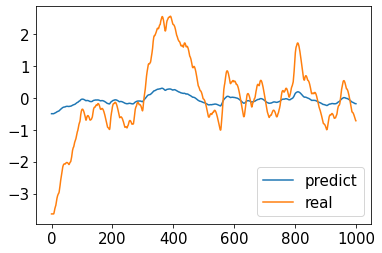

In [96]:
Vars = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
                 20, 20, 20, 20, 20, 20, 20, 20, 20,
                 -3, 5, 0])
y = model_non(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
plt.plot(y, label='predict')
plt.plot(Y_test_std[-1], label='real')
plt.legend()

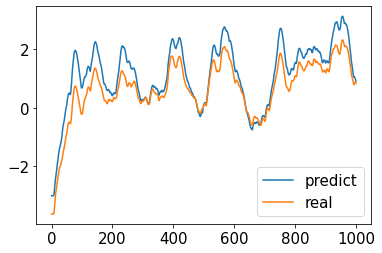

In [65]:
Vars = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1,
                 20, 20, 20, 20, 20, 20, 20, 20, 20,
                 -3])
y = model_l(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18])
plt.plot(y, label='predict')
plt.plot(Y_train_std[0], label='real')
plt.legend()

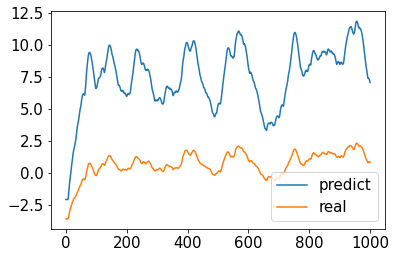

In [20]:
a = np.random.randn(8)
Vars = np.array([2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5,
                 20, 20, 20, 20, 20, 20, 20, 20, 20,
                 0.01, 
                 0.01, 0.01, 
                 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                 -2.1])
y = model(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:63], Vars[63])
plt.plot(y, label='predict')
plt.plot(Y_train_std[0], label='real')
plt.legend()

In [97]:
def evalVars(Vars):
    #y = hlm(X_train_array, Vars[0:9], Vars[9:18], Vars[18:63], Vars[63])
    #y = hlm_l(X_train_array, Vars[0:9], Vars[9:18], Vars[18])
    y = hlm_non(X_train_array, Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
    f = np.mean(np.square(y - Y_train_std))
    return f

In [98]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 100})
with open('pars/pars_nonlinear_passive_tau7.p', 'wb') as f:
    pickle.dump(res.x, f)

         Current function value: 0.029022
         Iterations: 100
         Function evaluations: 2486
         Gradient evaluations: 113


In [9]:
# load paraneters
with open('pars/pars_nonlinear_passive_tau7.p', 'rb') as fo:
    Vars_non = pickle.load(fo, encoding='bytes')
with open('pars/pars_linear_passive_tau7.p', 'rb') as fo:
    Vars_l = pickle.load(fo, encoding='bytes')
with open('pars/pars_bilinear_passive_tau7.p', 'rb') as fo:
    Vars_b = pickle.load(fo, encoding='bytes')
with open('pars/pars_bilinear_passive_tau7_real_ker.p', 'rb') as fo:
    Vars_br = pickle.load(fo, encoding='bytes')
Vars_l, Vars_non

(array([ 0.80072731,  0.77771306,  0.70766007,  0.46172265,  0.6715063 ,
         0.7881454 ,  0.74808258,  0.7716104 ,  0.89428183, 24.80528107,
        26.70742641, 26.35859893, 30.13048553, 26.03369593, 24.76495995,
        26.04422109, 26.10450503, 23.82214747, -3.20487421]),
 array([  0.18015455,   0.17967583,   0.16155673,   0.11117688,
          0.15237237,   0.17849082,   0.16803331,   0.17676504,
          0.20437488,  24.23587137,  26.0118988 ,  25.32331957,
         26.04277831,  25.56580856,  24.05757949,  25.73027974,
         25.64693086,  23.40392657, -17.83397256,  23.72010302,
         -0.41024523]))

In [59]:
res.x

array([ 1.26316912e-01,  1.27218122e-01,  1.16867080e-01,  8.24193443e-02,
        1.09743296e-01,  1.24686076e-01,  1.20563096e-01,  1.25056750e-01,
        1.37733079e-01,  2.53091954e+01,  2.57709175e+01,  2.47821211e+01,
        2.37820974e+01,  2.49832857e+01,  2.51290090e+01,  2.56280340e+01,
        2.58802112e+01,  2.59208125e+01, -1.69292920e+01,  2.69195240e+01,
       -2.22173136e-02])

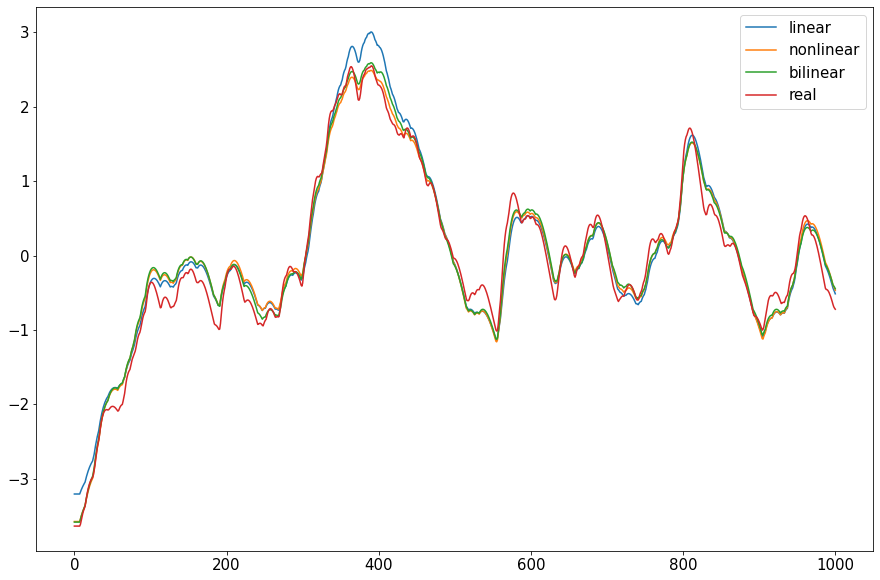

In [101]:
Vars = res.x
plt.figure(figsize=(15, 10))
y_b = model(X_test_array[-1], Vars_b[0:9], Vars_b[9:18], Vars_b[18:63], Vars_b[63])
y_l = model_l(X_test_array[-1], Vars_l[0:9], Vars_l[9:18], Vars_l[18])
y_non = model_non(X_test_array[-1], Vars_non[0:9], Vars_non[9:18], Vars_non[18], Vars_non[19], Vars_non[20])
plt.plot(y_l, label='linear')
plt.plot(y_non, label='nonlinear')
plt.plot(y_b, label='bilinear')
plt.plot(Y_test_std[-1], label='real')
plt.legend()

In [102]:
def variance_explained(x, y):
    err = np.sum(np.square(x - y))
    var = np.sum(np.square(y - np.mean(y)))
    return 1 - err / var

In [105]:
variance_explained(y_l, Y_test_std[-1])

0.9661375166258326

In [109]:
test_pred_b = hlm(X_test_array, Vars_b[0:9], Vars_b[9:18], Vars_b[18:63], Vars_b[63])
test_pred_l = hlm_l(X_test_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18])
test_pred_non = hlm_non(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18], Vars_non[19], Vars_non[20])
test_ve_b = np.empty(X_test_array.shape[0])
test_ve_l = np.empty(X_test_array.shape[0])
test_ve_non = np.empty(X_test_array.shape[0])
for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i], Y_test_std[i])
    test_ve_l[i] = variance_explained(test_pred_l[i], Y_test_std[i])
    test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])

In [112]:
np.mean(test_ve_b-test_ve_non)

-0.0015646414575257394

Text(0, 0.5, 'variance explained')

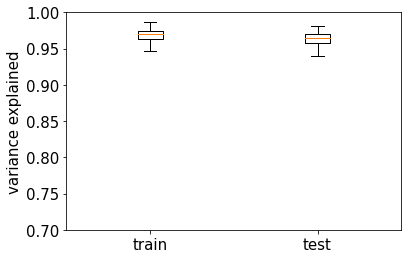

In [74]:
#test_pred = hlm(X_train_array, Vars_b[0:9], Vars_b[9:18], Vars_b[18:63], Vars_b[63])
test_pred = hlm_l(X_train_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18])
#test_pred = hlm_non(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18], Vars_non[19], Vars_non[20])
test_ve = np.empty(X_train_array.shape[0])
for i in range(len(test_ve)):
    test_ve[i] = variance_explained(test_pred[i], Y_train_std[i])

#tr_pred = hlm(X_train_array, Vars[0:9], Vars[9:18], Vars[18:63], Vars[63])
#tr_pred = hlm_l(X_train_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18])
tr_pred = hlm_non(X_train_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18], Vars_non[19], Vars_non[20])
tr_ve = np.empty(X_train_array.shape[0])

for i in range(len(tr_ve)):
    tr_ve[i] = variance_explained(tr_pred[i], Y_train_std[i])
p = ['train', 'test']
plt.boxplot([tr_ve, test_ve],showfliers=False,labels=['train','test'])
plt.ylim(0.7, 1)
plt.ylabel('variance explained')
#plt.savefig('figures/boxplot_linear_act_tau7_20Hz_sub',bbox_inches='tight')

/home/mjy/anaconda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'variance explained')

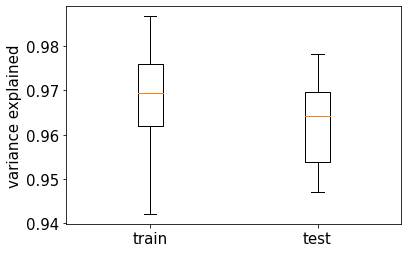

In [234]:
plt.boxplot([tr_ve, test_ve],showfliers=False,labels=['train','test'])
#plt.ylim(0.7, 1)
plt.ylabel('variance explained')

In [83]:
with open('data/Vsep_single_pulse_tau7.p', 'rb') as fo:
        Vsep = pickle.load(fo, encoding='bytes')
# with open('data/Vsep_1000.p', 'rb') as fo:
#         Vsep1000 = pickle.load(fo, encoding='bytes')
with open('data/Vsep_single_pulse_tau7_1000ms.p', 'rb') as fo:
        Vsep1000 = pickle.load(fo, encoding='bytes')
Vsep1000 += 62.5

In [13]:
def Ker(x,tau):
    return np.heaviside(x, 0)*(x)/tau*np.exp(-(x)/tau)

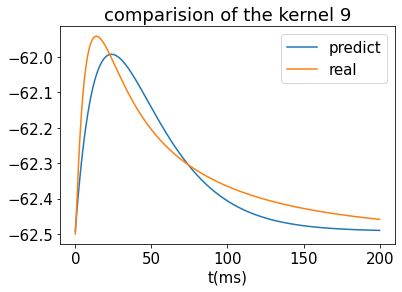

In [136]:
i = 8
tau = Vars_l[9:18]
omega = Vars_l[0:9]
Z = np.zeros(9)
x = np.linspace(0, 200, 201)
Vsepp = np.zeros(201)-62.5
Vsepp = Vsep[i]
y = omega[i] * Ker(x, tau[i])
plt.plot(x, (y-0.41+Vars_l[18])*np.std(Y_train)+np.mean(Y_train), label='predict')
plt.plot(x, Vsep1000[i][:201], label='real')
plt.title(f'comparision of the kernel {i+1}')
plt.xlabel('t(ms)')
plt.legend()
#plt.savefig(f'figures/kernel{i}_nodelay')

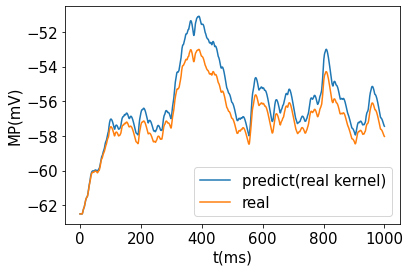

In [147]:
Vsep1000 += 62.5
x = np.zeros(time_dur)
y = np.zeros(time_dur)
x[0] = 1
for i in range(9):
    y += np.convolve(X_test_array[-1][i], Vsep1000[i])[:time_dur]
plt.plot(y-62.5, label='predict(real kernel)')
plt.plot(Y_test[-1], label='real')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()

In [39]:
def model_od(X, K):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        L[i] = np.convolve(X[i], Vsep1000[i])[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
        # for j in range(i+1):
        #         Y += -K[int(i*(i+1)/2)+j] * L[i] * L[j]
    return Y

def hlm_od(X, K):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_od(X[i], K)
    return Y

In [35]:
def model(X, K):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        L[i] = np.convolve(X[i], Vsep1000[i])[:time_dur]
        Y += L[i]
        if i > 0:
            # for j in range(i):
            #     Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
            for j in range(i+1):
                Y += -K[int(i*(i+1)/2)+j] * L[i] * L[j]
    return Y

def hlm(X, K):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], K)
    return Y

In [17]:
X = np.zeros((9, 1001))
X[0,0] = 1
X[0,100] = 1
Vars = np.array([0.01, 
            0.01, 0.01, 
            0.01, 0.01, 0.01, 
            0.01, 0.01, 0.01, 0.01, 
            0.01, 0.01, 0.01, 0.01, 0.01, 
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
            0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])#,
            #0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]) * 2.9

In [24]:
def evalVars(Vars):
    y = hlm(X_train_array, Vars)
    #y = hlm_non(X_train_array, Vars[0], Vars[1], Vars[2])
    f = np.mean(np.square(y - Y_train - 62.5))
    #f = np.mean(np.square(y - Y_train_std))
    return f

In [25]:
evalVars(Vars)

0.4049183120137563

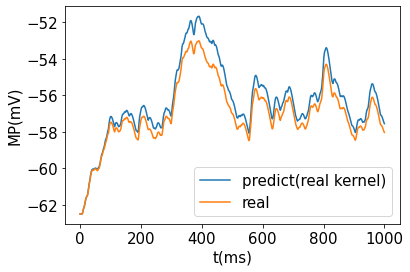

In [243]:
y = model(X_test_array[-1], Vars)
plt.plot(y-62.5, label='predict(real kernel)')
plt.plot(Y_test[-1], label='real')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()

In [26]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 100})

Optimization terminated successfully.
         Current function value: 0.012507
         Iterations: 22
         Function evaluations: 888
         Gradient evaluations: 24


In [28]:
with open('pars/pars_bilinear_passive_tau7_real_ker_off_diag.p', 'wb') as f:
    pickle.dump(res.x, f)

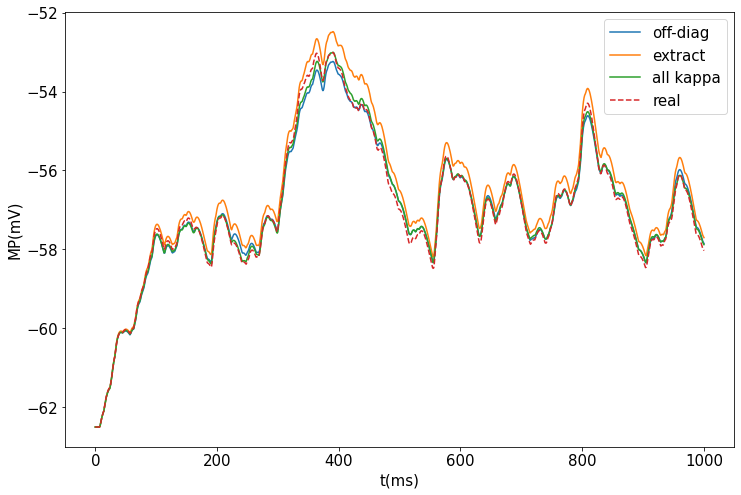

In [51]:
y = model_od(X_test_array[-1], res.x)
y2 = model_od(X_test_array[-1], Var_k)
y3 = model(X_test_array[-1], Vars_br)
plt.figure(figsize=(12, 8))
plt.plot(y-62.5, label='off-diag')
plt.plot(y2-62.5, label='extract')
plt.plot(y3-62.5, label='all kappa')
plt.plot(Y_test[-1], '--', label='real')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
plt.savefig('figure/compare_4')

In [211]:
def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model_non(X, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        Y += np.convolve(X_test_array[-1][i], Vsep1000[i])[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non(X, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non(X[i], v0, c, theta)
    return Y

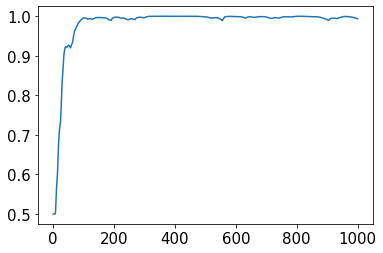

In [212]:
X = np.zeros((9, 1001))
Vars = np.array([0 , 1, 0])
y = model_non(X_test_array[-1], Vars[0], Vars[1], Vars[2])
plt.plot(y)
plt.plot()

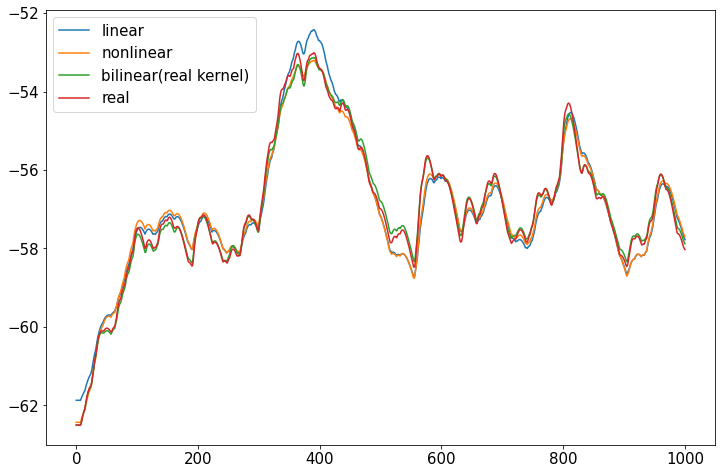

In [223]:
Vars = res.x
plt.figure(figsize=(12, 8))
y_b = model(X_test_array[-1], Vars_br)
y_l = model_l(X_test_array[-1], Vars_l[0:9], Vars_l[9:18], Vars_l[18])
y_non = model_non(X_test_array[-1], Vars_non[0:9], Vars_non[9:18], Vars_non[18], Vars_non[19], Vars_non[20])
plt.plot(y_l*np.std(Y_train)+np.mean(Y_train), label='linear')
plt.plot(y_non*np.std(Y_train)+np.mean(Y_train), label='nonlinear')
plt.plot(y_b-62.5, label='bilinear(real kernel)')
plt.plot(Y_test[-1], label='real')
plt.legend()
plt.savefig('figure/compare')

Text(0, 0.5, 'variance explained')

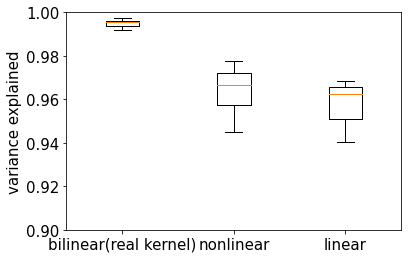

In [246]:
# test_pred_b = hlm(X_test_array, Vars_br)-62.5
# test_pred_l = hlm_l(X_test_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18])
# test_pred_non = hlm_non(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18], Vars_non[19], Vars_non[20])
# test_ve_b = np.empty(X_test_array.shape[0])
# test_ve_l = np.empty(X_test_array.shape[0])
# test_ve_non = np.empty(X_test_array.shape[0])
# for i in range(len(test_ve_b)):
#     test_ve_b[i] = variance_explained(test_pred_b[i], Y_test[i])
#     test_ve_l[i] = variance_explained(test_pred_l[i], Y_test_std[i])
#     test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])

p = ['bilinear(real kernel)', 'nonlinear', 'linear']
plt.boxplot([test_ve_b, test_ve_non, test_ve_l],showfliers=False,labels=p)
plt.ylim(0.9, 1)
plt.ylabel('variance explained')
#plt.savefig('figure/boxplot_compare',bbox_inches='tight')

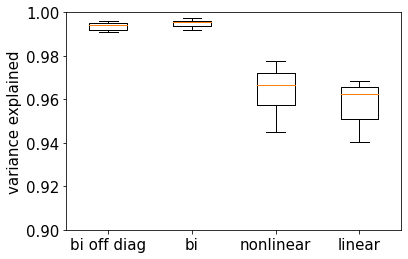

In [252]:
test_pred_bd = hlm(X_test_array, res.x)-62.5
test_ve_bd = np.empty(X_test_array.shape[0])
for i in range(len(test_ve_b)):
    test_ve_bd[i] = variance_explained(test_pred_bd[i], Y_test[i])
p = ['bi off diag','bi', 'nonlinear', 'linear']
plt.boxplot([test_ve_bd, test_ve_b, test_ve_non, test_ve_l],showfliers=False,labels=p)
plt.ylim(0.9, 1)
plt.ylabel('variance explained')
plt.savefig('figure/boxplot_compare_4',bbox_inches='tight')

In [33]:
res.x

array([0.03383467, 0.02778209, 0.04944389, 0.06835798, 0.06520975,
       0.10508436, 0.03423924, 0.04129115, 0.05076311, 0.05366635,
       0.03609043, 0.02532977, 0.02849838, 0.03825104, 0.0636718 ,
       0.04731654, 0.04160867, 0.04381823, 0.03736889, 0.03719833,
       0.04033127, 0.0339722 , 0.03246007, 0.035198  , 0.06576738,
       0.04501285, 0.03892825, 0.03020769, 0.02954835, 0.02598899,
       0.03198817, 0.03168805, 0.02582328, 0.03984878, 0.03469625,
       0.04040308])

In [29]:
with open('pars/pars_bilinear_passive_tau7_real_ker.p', 'rb') as fo:
    Vars_br = pickle.load(fo, encoding='bytes')

In [34]:
Vars_br

array([0.03905218, 0.02880845, 0.0353095 , 0.01397705, 0.03287591,
       0.05435969, 0.0204969 , 0.02810718, 0.05597842, 0.13398017,
       0.02197012, 0.02075629, 0.02695406, 0.01017272, 0.07081662,
       0.02788196, 0.01989525, 0.00749491, 0.02768216, 0.03977506,
       0.03769244, 0.02900417, 0.02143531, 0.02889272, 0.01022897,
       0.02249337, 0.02004842, 0.04181154, 0.02015255, 0.02803894,
       0.02343113, 0.03509381, 0.01164885, 0.01498253, 0.02699829,
       0.04124615, 0.02002316, 0.02536022, 0.02316677, 0.01238971,
       0.01758143, 0.03359152, 0.03226672, 0.03281086, 0.01493175])

In [47]:
def extract_kappa(K):
    idx = [0, 2, 5, 9, 14, 20, 27, 35, 44]
    return np.delete(K, idx)

In [48]:
Var_k = extract_kappa(Vars_br)

In [33]:
def biexponential(x, tau_rise, tau_decay):
    return (1 - np.exp(-x / tau_rise)) * np.exp(-x / tau_decay)

In [26]:
def triexponential(x, a, tau_rise, tau_fast, tau_slow):
    return (1 - np.exp(-x / tau_rise)) * (a * np.exp(-x / tau_fast) + (1 - a) * np.exp(-x / tau_slow))

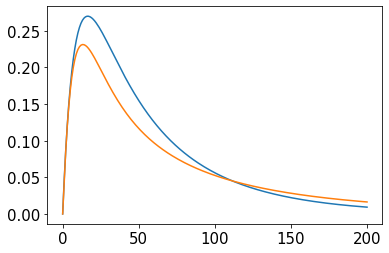

In [50]:
x = np.linspace(0, 200, 201)
y = 0.5 * triexponential(x, 0.5, 10, 30, 60)
plt.plot(y)
plt.plot(object0)

In [55]:
def alpha(x, tau):
    return (x / tau) * np.exp(-(x / tau))

In [29]:
with open('data/Vsep_active.p', 'rb') as fo:
    Vsep = pickle.load(fo, encoding='bytes')

In [56]:
object0 = Vsep[0].copy()
object0 -= min(object0)
x = np.linspace(0, 200, 201)
#Vars = [0.5, 0.5, 10, 30, 60]
Vars = [1, 1]
def evalVars(Vars):
    #y = Vars[0] * triexponential(x, Vars[1], Vars[2], Vars[3], Vars[4])
    y = Vars[0] * alpha(x, Vars[1])
    f = np.mean((y - object0)**2)
    return f

In [52]:
evalVars(Vars)

0.0005685539795255768

In [57]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 100})

Optimization terminated successfully.
         Current function value: 0.000608
         Iterations: 29
         Function evaluations: 99
         Gradient evaluations: 33


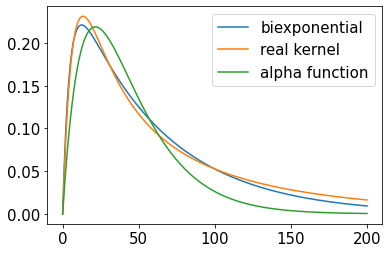

In [59]:
Vars_a = res.x
y1 = Vars_bi[0] * biexponential(x, Vars_bi[1], Vars_bi[2])
y2 = Vars_a[0] * alpha(x, Vars_a[1])
#y3 = Vars_tri[0] * triexponential(x, Vars_tri[1], Vars_tri[2], Vars_tri[3], Vars_tri[4])
plt.plot(y1, label='biexponential')
plt.plot(object0, label='real kernel')
plt.plot(y2, label='alpha function')
#plt.plot(y3, label='tri')
plt.legend()
plt.savefig('figure/kernel_fit_active')

In [95]:
res.x

array([ 0.84662826,  7.78658049, 53.43380186])